In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import zscore
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-market-dataset/Test_small_features.csv
/kaggle/input/stock-market-dataset/Description.docx
/kaggle/input/stock-market-dataset/Train_full.csv


**Đọc dữ liệu****

In [2]:
data = pd.read_csv('/kaggle/input/stock-market-dataset/Train_full.csv')
data = data.drop(columns = data.columns[0])

**Xem tât cả các đặc trưng dữ liệu**

In [3]:
data.columns.values

array(['Open', 'High', 'Low', 'Close', 'Volume', 'body', 'upper_tail',
       'lower_tail', 'SMA_50', 'SMA_20', 'ATR', 'CCI', 'SAR', 'hour',
       'min', 'dayofweek', 'JPY', 'AUD', 'EUR', 'GBP', 'USD',
       'lag_return_1', 'return_2', 'lag_return_2', 'return_3',
       'lag_return_3', 'return_4', 'lag_return_4', 'return_5',
       'lag_return_5', 'return_6', 'lag_return_6', 'return_7',
       'lag_return_7', 'return_8', 'lag_return_8', 'return_9',
       'lag_return_9', 'return_10', 'lag_return_10', 'return_11',
       'lag_return_11', 'return_12', 'lag_return_12', 'return_13',
       'lag_return_13', 'return_14', 'lag_return_14', 'return_15',
       'lag_return_15', 'return_16', 'lag_return_16', 'return_17',
       'lag_return_17', 'return_18', 'lag_return_18', 'return_19',
       'lag_return_19', 'return_20', 'lag_return_20', 'return_21',
       'lag_return_21', 'return_22', 'lag_return_22', 'return_23',
       'lag_return_23', 'return_24', 'lag_return_24', 'return_25',
       'la

**Nhìn vào dữ liệu ta thấy thiếu đặc trưng return_1, theo tính chất của dữ liệu thì return_1 = return_2 - lag_return_1**

In [5]:
data['return_1'] = data['return_2'] - data['lag_return_1']
data.shape

(709314, 214)

**Kiểm tra giá trị còn thiếu trong dữ liệu**

In [6]:
data.isnull().values.sum()

0

**Lọc ngoại lệ với phương Z_Score với ngưỡng =  4 **

In [7]:
z_scores = stats.zscore(data)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 4).all(axis=1)
df = data[filtered_entries]

**Chia ra biến đoc lập và biến phụ thuộc**

In [8]:
Y = df["up_down"] #independent columns
X = df.drop(columns="up_down")
columns = X.columns

**Sử dụng MinMax để chuấn hóa dữ liệu**

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)

**Sử dụng feature_importances từ model lightgbm để chọn feature **

[ 12   6   5   3 102  53  65  70   9   6  86  13  10 134  87   4   0   0
  12   3   2  28  36  15  29  18  22  31  38  11  16  19  17  16  18  23
  13  17  14  25  19  12   8  16   7  21  10  23   4  10   8  13  13  27
  20  15  19  15   7  17  11  13   5  10   5  14   5  18   5  17   8   9
   2  10  10  12   6  14   4  20   6  15   8  23   9  11   5  18   3  15
  15  15   4  23   5   7   6  13   4  18   6   9   7  16   4  23   1  11
   8  16   1  17   7   9   3  17   6  16   4  15   3  17   1  13   3  19
   6  24   5  11   6  21   7  14   3  15   2  20   6   7   3  27   3  13
   5  10   2  14   6  19   4  16   4  18   3  13   6  17   4  14   4  21
   3  24   4  17   3  17   6  13   2  13   9  12   5  15   4  16   5  19
   2  14   2  19   3  19   4  19   5  20   7  19   2  23   2  17   2  20
   4  16   6  24   7  19   5  16   6  23   2  13   2  11  42]


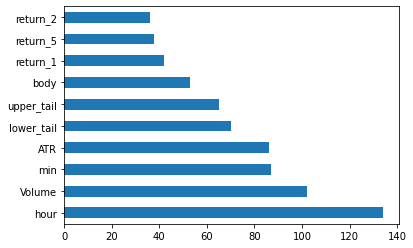

In [10]:
import lightgbm as lgb
import matplotlib.pyplot as plt
model = lgb.LGBMClassifier()
model.fit(X_scale, Y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [11]:
feature_importances =["hour","Volume","min","ATR","lower_tail","upper_tail","body","return_1","return_5","return_2"]

In [12]:
x=X[feature_importances]
y=Y

**Sử dụng Kfold để đánh giá **

In [13]:
##from sklearn.model_selection import train_test_split
##X_train,X_test,Y_train,Y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
kf = KFold(n_splits=10)
kf.get_n_splits(x)
print(kf)
KFold(n_splits=10, random_state=None, shuffle=False)
i=0
A=0
P=0
R=0
F=0
for train_index, test_index in kf.split(x):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]     
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    from xgboost import XGBClassifier
    model = XGBClassifier()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
Y_pred = model.predict(X_test)
    i=i+1
    print("so luong tap train ",i,": ",X_train.shape[0])
    print("so luong tap test ",i,": ",X_train.shape[0])
    accuracy = accuracy_score(Y_test,Y_pred)
    print("Accuracy: %.2f%%",(accuracy * 100.0))
    A=A+accuracy
    from sklearn.metrics import precision_score
    print("Precision = ",precision_score(Y_test, Y_pred))
    P=P+precision_score(Y_test, Y_pred)
    from sklearn.metrics import recall_score
    print("Recall = ",recall_score(Y_test, Y_pred))
    R=R+recall_score(Y_test, Y_pred)
    from sklearn.metrics import f1_score
    print("F-measure = ",f1_score(Y_test, Y_pred))
    F=F+f1_score(Y_test, Y_pred)
print("Trung binh Accuracy = ", A/10)
print("Trung binh Precision = ", P/10)
print("Trung binh Recall = ", R/10)
print("Trung binh F-measure = ",F/10)

KFold(n_splits=10, random_state=None, shuffle=False)
Accuracy =  0.7085825955172689
Precision =  0.52089976730156
Recall =  0.4002914100271541
F-measure =  0.45270017227174003
Accuracy =  0.791816223977028
Precision =  0.5194387605963169
Recall =  0.49183504013285356
F-measure =  0.5052601649132784
Accuracy =  0.7090753185634235
Precision =  0.5370342882588689
Recall =  0.4642330146917303
F-measure =  0.49798699287705167
Accuracy =  0.7416196382635053
Precision =  0.5274586939417781
Recall =  0.4909556938850238
F-measure =  0.5085530058790063
Accuracy =  0.737870660258839
Precision =  0.5202655755423454
Recall =  0.4929773226042429
F-measure =  0.5062539909101155
Accuracy =  0.7000618182543322
Precision =  0.5193573501309364
Recall =  0.4707467282525019
F-measure =  0.49385873405794667
Accuracy =  0.6935011067461663
Precision =  0.5308976737548166
Recall =  0.4582409460458241
F-measure =  0.49190082644628097
Accuracy =  0.7050671027180091
Precision =  0.5294559663360384
Recall =  0.452